In [1]:
%cd /Users/yantong/Desktop/NLP\ for\ Risk/Code/

/Users/yantong/Desktop/NLP for Risk/Code


## Import Libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [4]:
import jieba as jb
import re

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Sequential


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
 
from sklearn.model_selection import cross_val_score


In [7]:
from sklearn.model_selection import GridSearchCV


In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth",None)
pd.set_option('display.width',None)

In [9]:
import json

## Read Data

In [10]:
split_data = pd.read_csv('data_sim.csv')

In [11]:
from ast import literal_eval

In [12]:
newvalues = split_data.copy()
newvalues['baidu_seg'] = newvalues['baidu_seg'].apply(lambda row: literal_eval(row))

In [13]:
len(''.join(newvalues.loc[19852,'baidu_seg']))

421

In [14]:
newvalues.loc[19852]

Unnamed: 0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        19852
baidu_seg     [报告, 大厅, 权威, 发布, 2020年, 中国, LED, 显示屏, 上市公司, 利润, 规模, 排行榜, 一季度, 2020年, 一季度, LED, 显示屏, 上市公司, 利润, 总额, 7149.86万元, 前, 2家, 企业利润, 总额, 占, 2.21%, 榜单, 2家, 公司, 利润, 规模, 超过, 568万元, 大关, 排名前, 两家, 突破, 411万元, 568万元, 深圳雷曼光电科技股份有限公司, 太龙(福建)商业照明股份有限公司, 深圳雷曼光电科技股份有限公司, 成为, 2020年, LED, 显示屏, 利润, 规模, 最大, 中国, 公司, 利润, 高达, 411.13万元, 太龙(福建)商业照明股份有限公司, 紧随, 其后, 利润, 达到, 568.84万元, 具体, 详细, 排名, 情况, 报告, 大厅, 2020年, 中国, LED, 显示屏, 上市公司, 利润, 规模, 排行榜, 一季度, 数据, 统计, 显示, 前, 4家, 利润, 总额, 企业,

In [15]:
newvalues = newvalues[['baidu_seg','baidu_prob']]

## Data Preparation

In [16]:
newvalues['label'] = newvalues['baidu_prob'].apply(lambda row: 1 if row>0.95 else 0)

<AxesSubplot:>

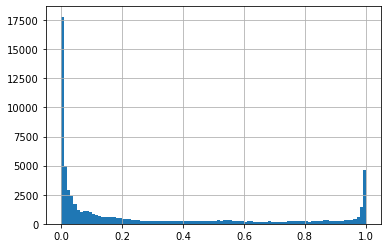

In [17]:
newvalues.baidu_prob.hist(bins = 100)

In [18]:
newvalues.label.value_counts()

0    59369
1     7391
Name: label, dtype: int64

In [19]:
newvalues.shape

(66760, 3)

#### 删除 \u3000

In [20]:
def del_u3000(lst):
    lst = [x for x in lst if not '\\u3000' in x]
    return lst

In [21]:
newvalues.baidu_seg = newvalues.baidu_seg.apply(lambda s: [x for x in s if not '\\u3000' in x])

#### 统计segmentation字数

In [22]:
len(''.join(newvalues.loc[19852,'baidu_seg']))

421

In [23]:
newvalues['word_counts'] = newvalues.baidu_seg.apply(lambda row: len(''.join(row)))

<AxesSubplot:>

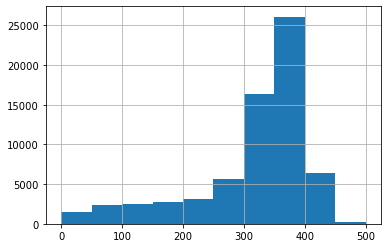

In [24]:
newvalues.word_counts.hist()

In [25]:
newvalues[newvalues.word_counts <= 150].shape

(6402, 4)

In [26]:
newvalues = newvalues[newvalues.word_counts > 150]
newvalues = newvalues.reset_index()

In [27]:
#c = [3245,5861,5863,6678,6681,10257]

In [28]:
#newvalues = newvalues.drop(c)

In [29]:
newvalues = newvalues.drop(['index'],axis = 1)

In [30]:
#newvalues.loc[10257]

In [31]:
for i in range(newvalues.shape[0]):
    if len(newvalues.loc[i,'baidu_seg']) == 20:
        print(i)

In [190]:
newvalues.loc[19852,'baidu_prob']

0.441775

In [404]:
#newvalues.loc[19852,'baidu_seg']

In [94]:
# 19852,28322
newvalues = newvalues.drop(28322)

In [95]:
# 19852,28322
newvalues = newvalues.drop(28322)
newvalues = newvalues.reset_index()

## Imbalanced

In [32]:
from collections import Counter
Counter(newvalues.label)

Counter({0: 53457, 1: 6901})

### Resampling -- Oversampling

In [33]:
X = np.array(newvalues.baidu_seg).reshape(-1,1)
y = newvalues.label

#### Naive Ramdom Over-sampling

In [34]:
from imblearn.over_sampling import RandomOverSampler

In [35]:
X = newvalues['baidu_seg']
y = newvalues['label']

## Modelling

In [36]:
# performance
performance_df = pd.DataFrame()


In [37]:

def perform(model_name,performance,performance_df):
    perform_1 = pd.DataFrame(performance['detail']['1'],index = [model_name])
    perform_0 = pd.DataFrame(performance['detail']['0'],index = [model_name])
    perform_macro = pd.DataFrame(performance['detail']['macro avg'],index = [model_name])
    perform_weighted = pd.DataFrame(performance['detail']['weighted avg'],index = [model_name])
    performance_model = pd.DataFrame()
    performance_model.loc[model_name,'accuracy'] = performance['detail']['accuracy']    
    
    performance_model = pd.concat([performance_model,perform_1,perform_0,perform_macro,perform_weighted],axis = 1)    
    performance_df = pd.concat([performance_df,performance_model],axis = 0)
    return performance_df

In [38]:
# performance = cnn_performance
# model_name = 'cnn'
# performance_df = perform(model_name,performance,performance_df)
# performance_df

In [39]:
# performance

def sklearn_perform(model_name,performance,performance_df):
    perform_1 = pd.DataFrame(performance['1'],index = [model_name])
    perform_0 = pd.DataFrame(performance['0'],index = [model_name])
    perform_macro = pd.DataFrame(performance['macro avg'],index = [model_name])
    perform_weighted = pd.DataFrame(performance['weighted avg'],index = [model_name])
    performance_model = pd.DataFrame()
    performance_model.loc[model_name,'accuracy'] = performance['accuracy']    
    
    performance_model = pd.concat([performance_model,perform_1,perform_0,perform_macro,perform_weighted],axis = 1)    
    performance_df = pd.concat([performance_df,performance_model],axis = 0)
    return performance_df

### Model 1.1: TF-IDF + CNN

In [40]:
import kashgari
from kashgari import utils
from kashgari.embeddings import BertEmbedding
from kashgari.tasks.labeling import BiLSTM_CRF_Model
# from data_load import DataReader

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [41]:
from sklearn.model_selection import train_test_split


In [42]:
from tensorflow.keras.callbacks import TensorBoard
from kashgari.tasks.classification import CNN_Model

In [43]:
#from sklearn.feature_extraction.text import TfidfVectorizer
 
#tfidf = TfidfVectorizer(norm='l2', ngram_range=(1, 2))
#vectorizer = CountVectorizer()    
#features = tfidf.fit_transform(vectorizer.fit_transform(labeled_data_3.content_cut))
#labels = labeled_data_3.label
#print(features.shape)
#print('-----------------------------')
#print(features)
#print(labels)

In [44]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, 
                                                                                 newvalues.index, 
                                                                                 test_size=0.2, stratify=y, random_state=0)
X_test = X_test.tolist()
y_test = y_test.tolist()



X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(X_train, y_train, 
                                                                                 indices_train, 
                                                                                 test_size=0.05, stratify=y_train, random_state=0)

X_train = X_train.tolist()
y_train = y_train.tolist()
X_val = X_val.tolist()
y_val = y_val.tolist()



In [45]:
# Using TensorBoard record training process
tf_board = TensorBoard(log_dir='tf_dir/cnn_model_split_fb_wx',
                       histogram_freq=5,
                       update_freq='batch')


In [46]:
model = CNN_Model()
model.fit(X_train, y_train, X_val, y_val,
          batch_size=128,
          callbacks=[tf_board])

Preparing text vocab dict: 100%|██████████| 2415/2415 [00:00<00:00, 20927.59it/s]
2021-01-05 14:40:42,181 [DEBUG] kashgari - --- Build vocab dict finished, Total: 100755 ---
2021-01-05 14:40:42,182 [DEBUG] kashgari - Top-10: ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '项目', '企业', '工程', '建设', '公司', '施工']
Calculating sequence length: 100%|██████████| 2415/2415 [00:00<00:00, 1036982.41it/s]
2021-01-05 14:40:42,399 [DEBUG] kashgari - Calculated sequence length = 186
2021-01-05 14:40:42,446 [DEBUG] kashgari - Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
layer_embedding (Embedding)  (None, None, 100)         10075500  
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         64128     
__________________

Epoch 1/5
358/358 [==============================] - 46s 127ms/step - loss: 0.3170 - accuracy: 0.8945 - val_loss: 0.1790 - val_accuracy: 0.9275
Epoch 2/5
358/358 [==============================] - 45s 127ms/step - loss: 0.1308 - accuracy: 0.9471 - val_loss: 0.2109 - val_accuracy: 0.9314
Epoch 3/5
358/358 [==============================] - 44s 123ms/step - loss: 0.0375 - accuracy: 0.9877 - val_loss: 0.2251 - val_accuracy: 0.9397
Epoch 4/5
358/358 [==============================] - 44s 122ms/step - loss: 0.0103 - accuracy: 0.9975 - val_loss: 0.2283 - val_accuracy: 0.9449
Epoch 5/5
358/358 [==============================] - 45s 125ms/step - loss: 0.0053 - accuracy: 0.9988 - val_loss: 0.2648 - val_accuracy: 0.9384


In [47]:
import os
import joblib
os.chdir("saved_model_split_fb_wx")
model.save('tfidf_cnn')

2021-01-05 14:44:27,253 [INFO] kashgari - model saved to /Users/yantong/Desktop/NLP for Risk/Code/saved_model_split_fb_wx/tfidf_cnn


'/Users/yantong/Desktop/NLP for Risk/Code/saved_model_split_fb_wx/tfidf_cnn'

In [48]:
os.chdir("..")

In [49]:
tf_idf_cnn_performance = model.evaluate(X_test, y_test)

2021-01-05 14:44:27,267 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 245
2021-01-05 14:44:28,563 [DEBUG] kashgari - predict input shape (12072, 245) x: 
[[    2 57930 78052 ...     0     0     0]
 [    2 11232 13604 ...     0     0     0]
 [    2 14994     4 ...     0     0     0]
 ...
 [    2 66130 52356 ...     0     0     0]
 [    2 16006   239 ...     0     0     0]
 [    2  8218  2997 ...     0     0     0]]
2021-01-05 14:44:30,613 [DEBUG] kashgari - predict output shape (12072, 2)
2021-01-05 14:44:30,621 [DEBUG] kashgari - predict output argmax: [0 0 0 ... 0 0 0]


              precision    recall  f1-score   support

           0     0.9532    0.9719    0.9625     10692
           1     0.7436    0.6304    0.6824      1380

    accuracy                         0.9329     12072
   macro avg     0.8484    0.8012    0.8224     12072
weighted avg     0.9293    0.9329    0.9305     12072



In [50]:
performance = tf_idf_cnn_performance
model_name = 'TF-IDF_CNN'
performance_df = perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.932903,0.74359,0.630435,0.682353,1380,0.95322,0.971942,0.96249,10692,0.848405,0.801188,0.822421,12072,0.929256,0.932903,0.930466,12072


### Model 1.2: TF-IDF + CNN + Naive Random Sampling

In [51]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, 
                                                                                 newvalues.index, 
                                                                                 test_size=0.2, stratify=y, random_state=0)
X_test = X_test.tolist()
y_test = y_test.tolist()

X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(X_train, y_train, 
                                                                                 indices_train, 
                                                                                 test_size=0.05, stratify=y_train, random_state=0)

X_train = X_train.tolist()
y_train = y_train.tolist()
X_val = X_val.tolist()
y_val = y_val.tolist()

In [52]:
X_resampling = np.array(X_train).reshape(-1,1)
y_resampling = y_train
ros = RandomOverSampler(random_state=0)
X_resampled_naive, y_resampled_naive = ros.fit_resample(X_resampling, y_resampling)

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [53]:
# Using TensorBoard record training process
tf_board = TensorBoard(log_dir='tf_dir/cnn_model_naive_resampling_split_fb_wx',
                       histogram_freq=5,
                       update_freq='batch')


In [54]:
model = CNN_Model()
model.fit(X_train, y_train, X_val, y_val,
          batch_size=128,
          callbacks=[tf_board])

Preparing text vocab dict: 100%|██████████| 2415/2415 [00:00<00:00, 19333.50it/s]
2021-01-05 14:44:34,374 [DEBUG] kashgari - --- Build vocab dict finished, Total: 100755 ---
2021-01-05 14:44:34,375 [DEBUG] kashgari - Top-10: ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '项目', '企业', '工程', '建设', '公司', '施工']
Calculating sequence length: 100%|██████████| 2415/2415 [00:00<00:00, 1069049.52it/s]
2021-01-05 14:44:34,601 [DEBUG] kashgari - Calculated sequence length = 186
2021-01-05 14:44:34,649 [DEBUG] kashgari - Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
layer_embedding (Embedding)  (None, None, 100)         10075500  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         64128     
__________________

Epoch 1/5
358/358 [==============================] - 50s 137ms/step - loss: 0.3271 - accuracy: 0.8810 - val_loss: 0.1820 - val_accuracy: 0.9284
Epoch 2/5
358/358 [==============================] - 42s 119ms/step - loss: 0.1312 - accuracy: 0.9463 - val_loss: 0.1815 - val_accuracy: 0.9375
Epoch 3/5
358/358 [==============================] - 40s 110ms/step - loss: 0.0409 - accuracy: 0.9862 - val_loss: 0.2268 - val_accuracy: 0.9410
Epoch 4/5
358/358 [==============================] - 41s 114ms/step - loss: 0.0093 - accuracy: 0.9972 - val_loss: 0.2491 - val_accuracy: 0.9431
Epoch 5/5
358/358 [==============================] - 41s 115ms/step - loss: 0.0061 - accuracy: 0.9986 - val_loss: 0.2715 - val_accuracy: 0.9392


In [55]:
import os
import joblib
os.chdir("saved_model_split_fb_wx")
model.save('tfidf_cnn_naive_resampling')

2021-01-05 14:48:09,073 [INFO] kashgari - model saved to /Users/yantong/Desktop/NLP for Risk/Code/saved_model_split_fb_wx/tfidf_cnn_naive_resampling


'/Users/yantong/Desktop/NLP for Risk/Code/saved_model_split_fb_wx/tfidf_cnn_naive_resampling'

In [56]:
os.chdir("..")

In [57]:
tfidf_cnn_naive_resampling_performance = model.evaluate(X_test, y_test)

2021-01-05 14:48:09,088 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 245
2021-01-05 14:48:09,834 [DEBUG] kashgari - predict input shape (12072, 245) x: 
[[    2 57930 78052 ...     0     0     0]
 [    2 11232 13604 ...     0     0     0]
 [    2 14994     4 ...     0     0     0]
 ...
 [    2 66130 52356 ...     0     0     0]
 [    2 16006   239 ...     0     0     0]
 [    2  8218  2997 ...     0     0     0]]
2021-01-05 14:48:11,670 [DEBUG] kashgari - predict output shape (12072, 2)
2021-01-05 14:48:11,679 [DEBUG] kashgari - predict output argmax: [0 0 0 ... 0 0 0]


              precision    recall  f1-score   support

           0     0.9539    0.9682    0.9610     10692
           1     0.7213    0.6377    0.6769      1380

    accuracy                         0.9304     12072
   macro avg     0.8376    0.8029    0.8190     12072
weighted avg     0.9273    0.9304    0.9285     12072



In [58]:
performance = tfidf_cnn_naive_resampling_performance
model_name = 'TF-IDF_CNN_naive_resampling'
performance_df = perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.932903,0.743590,0.630435,0.682353,1380,0.953220,0.971942,0.96249,10692,0.848405,0.801188,0.822421,12072,0.929256,0.932903,0.930466,12072
TF-IDF_CNN_naive_resampling,0.930417,0.721311,0.637681,0.676923,1380,0.953926,0.968201,0.96101,10692,0.837619,0.802941,0.818967,12072,0.927334,0.930417,0.928535,12072


### Model 2.1: 现有样本训练Word2Vec + LR

In [173]:
with open('./stopwords.txt', encoding='utf8') as file:
    line_list = file.readlines()
    stopword_list = [k.strip() for k in line_list]
    stopword_set = set(stopword_list)
    print('停顿词列表，即变量stopword_list中共有%d个元素' %len(stopword_list))
    print('停顿词集合，即变量stopword_set中共有%d个元素' %len(stopword_set))

停顿词列表，即变量stopword_list中共有782个元素
停顿词集合，即变量stopword_set中共有782个元素


In [174]:
#cutWords_List = []
#startTime = time.time()
#content_series = newvalues['baidu_seg']
#for i in range(len(content_series)):
#    content = content_series.iloc[i]
#    cutWords = [k for k in content]
#    if (i + 1) % 3000 == 0:
#        usedTime = time.time() - startTime
#        print('前%d篇文章分词共花费%.2f秒' %(i+1, usedTime))
#    cutWords_list.append(cutWords)

In [175]:
cutWords_list = newvalues['baidu_seg']

In [176]:
import time
from gensim.models import Word2Vec
startTime = time.time()
word2vec_model = Word2Vec(cutWords_list, size=200, iter=10, min_count=20)
usedTime = time.time() - startTime
print('形成word2vec模型共花费%.2f秒' %usedTime)

形成word2vec模型共花费70.01秒


In [177]:
import warnings
warnings.filterwarnings('ignore')

In [178]:
word2vec_model.wv.most_similar('建筑')
# word2vec_model.similarity('治愈','感染')

[('建筑工程', 0.6348114609718323),
 ('建筑业', 0.47198110818862915),
 ('装配式建筑', 0.45083144307136536),
 ('建筑设计', 0.44584178924560547),
 ('建筑类', 0.43347591161727905),
 ('市政工程', 0.4078594744205475),
 ('绿色建筑', 0.3978150188922882),
 ('建筑施工企业', 0.3893491327762604),
 ('装修', 0.3878200650215149),
 ('建造', 0.3706211745738983)]

#### Word2Vec 

In [179]:
import numpy as np

def get_contentVector(cutWords, word2vec_model):
    vector_list = [word2vec_model.wv[k] for k in cutWords if k in word2vec_model]
    contentVector = np.array(vector_list).mean(axis=0)
    return contentVector

In [180]:
import time

startTime = time.time()
contentVector_list = []
for i in range(len(cutWords_list)):
    cutWords = cutWords_list[i]
    if (i+1) % 3000 == 0:
        usedTime = time.time() - startTime
        print('前%d篇文章内容表示成向量共花费%.2f秒' %(i+1, usedTime))
    contentVector_list.append(list(get_contentVector(cutWords, word2vec_model)))
X = np.array(contentVector_list)

前3000篇文章内容表示成向量共花费2.53秒
前6000篇文章内容表示成向量共花费4.62秒
前9000篇文章内容表示成向量共花费6.86秒
前12000篇文章内容表示成向量共花费8.76秒
前15000篇文章内容表示成向量共花费10.55秒
前18000篇文章内容表示成向量共花费12.32秒
前21000篇文章内容表示成向量共花费14.09秒
前24000篇文章内容表示成向量共花费15.83秒
前27000篇文章内容表示成向量共花费17.63秒
前30000篇文章内容表示成向量共花费19.66秒
前33000篇文章内容表示成向量共花费21.58秒
前36000篇文章内容表示成向量共花费23.65秒
前39000篇文章内容表示成向量共花费25.75秒
前42000篇文章内容表示成向量共花费27.66秒
前45000篇文章内容表示成向量共花费29.66秒
前48000篇文章内容表示成向量共花费31.77秒
前51000篇文章内容表示成向量共花费33.63秒
前54000篇文章内容表示成向量共花费35.42秒
前57000篇文章内容表示成向量共花费37.78秒
前60000篇文章内容表示成向量共花费39.71秒


In [181]:
i 

60341

In [182]:
X.shape # check

(60342, 200)

In [183]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
y = list(labelEncoder.fit_transform(newvalues['label']))

In [184]:
#word2vec_gb_wx = pd.DataFrame(X)
#word2vec_gb_wx['label'] = y

In [ ]:
#word2vec_gb_wx.to_csv('word2vec_gb_wx.csv')

In [171]:
# remove data points
# 13709 * 6 ,29981 * 4,37189 * 2, 37764 * 4
# 地名 重复数字
newvalues = newvalues.drop(37764)
newvalues = newvalues.reset_index()
newvalues = newvalues.drop(['index'],axis = 1)


In [172]:
newvalues.loc[37764]

baidu_seg      [工程, 建设, 项目, 建设, 团队, 始终, 坚持, 严格, 控, 项目, 质量, 管理, 不断, 完善, 各项, 质量, 管理, 制度, 注重, 过程, 监督, 检查, 加强, 试验, 测量, 原材料, 管控, 影响, 工程, 实体, 质量, 环节, 进行, 重点, 检查, 开展, 质量, 通病, 治理, 不断, 改进, 施工, 工艺, 工程, 质量, 管理, 取得, 显著, 成效, 检测, 桥梁, 涵洞, 几何, 尺寸, 控制, 准确, 曲线, 流畅, 混凝土, 平整, 密实, 光洁, 美观, 隧道, 工程, 结构, 安全, 可靠, 沥青, 路面, 行车, 平稳, 舒适, 绿化, 实现, 全, 覆盖, 互通, 隧道, 两端, 采用, 保护, 原生, 植物, 方式, 极大, 提高, 绿化, 观赏性, 实现, 工程, 自然景观, 完美, 融合, 项目, 竣工, 验收, 综合, 得分, 96.5分, ...]
baidu_prob                                                                                                                                                                                                                                                                                                                                                                                                                      0.00104759
label                                                                                                                                             

#### Logistic Regression Models

In [185]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [186]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [187]:
X = np.array(X)

In [188]:
train_X_lr, test_X_lr, train_y_lr, test_y_lr = train_test_split(X, y, test_size=0.2)

In [189]:
logisticRegression_model = LogisticRegression()
logisticRegression_model.fit(train_X_lr, train_y_lr)
logisticRegression_model.score(test_X_lr, test_y_lr)

0.9250973568646946

In [190]:
y_pred_lr = logisticRegression_model.predict(test_X_lr)

In [191]:
print(classification_report(test_y_lr, y_pred_lr,digits=4))

              precision    recall  f1-score   support

           0     0.9423    0.9754    0.9586     10722
           1     0.7281    0.5249    0.6100      1347

    accuracy                         0.9251     12069
   macro avg     0.8352    0.7501    0.7843     12069
weighted avg     0.9184    0.9251    0.9197     12069



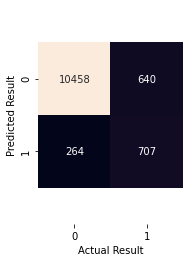

In [192]:
mat = confusion_matrix( y_pred_lr,test_y_lr)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [193]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

In [194]:
predslog = logisticRegression_model.predict_proba(test_X_lr)[:,1]
metrics.roc_auc_score(test_y_lr,predslog, average='macro', sample_weight=None)

0.9469415824120615

In [195]:
def plot_roc(labels, predict_prob):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')

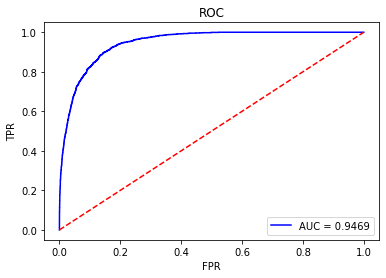

In [196]:
plot_roc(test_y_lr,predslog)

In [197]:
fbwx_w2v_lr_performance = classification_report(test_y_lr, y_pred_lr,digits=4,output_dict=True)
performance = fbwx_w2v_lr_performance
model_name = 'fbwx_w2v_LR'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.932903,0.743590,0.630435,0.682353,1380,0.953220,0.971942,0.962490,10692,0.848405,0.801188,0.822421,12072,0.929256,0.932903,0.930466,12072
TF-IDF_CNN_naive_resampling,0.930417,0.721311,0.637681,0.676923,1380,0.953926,0.968201,0.961010,10692,0.837619,0.802941,0.818967,12072,0.927334,0.930417,0.928535,12072
fbwx_w2v_LR,0.869169,0.784451,0.715895,0.748607,3284,0.897156,0.926466,0.911575,8785,0.840804,0.821180,0.830091,12069,0.866489,0.869169,0.867231,12069
fbwx_w2v_LR_naive_resampling,0.861878,0.779078,0.698532,0.736609,3337,0.889170,0.924301,0.906396,8732,0.834124,0.811417,0.821502,12069,0.858730,0.861878,0.859451,12069
fbwx_w2v_LR,0.925097,0.728115,0.524870,0.610009,1347,0.942332,0.975378,0.958570,10722,0.835224,0.750124,0.784289,12069,0.918424,0.925097,0.919668,12069


### Model 2.2: 现有样本训练Word2Vec + LR + Naive Resampling

In [205]:
X = newvalues['baidu_seg']
y = newvalues['label']

#### Word2Vec

In [206]:
cutWords_list = newvalues['baidu_seg']

startTime = time.time()
contentVector_list = []
for i in range(len(cutWords_list)):
    cutWords = cutWords_list[i]
#    if (i+1) % 3000 == 0:
#        usedTime = time.time() - startTime
#        print('前%d篇文章内容表示成向量共花费%.2f秒' %(i+1, usedTime))
    contentVector_list.append(list(get_contentVector(cutWords, word2vec_model)))
X = np.array(contentVector_list)

In [207]:
X = np.array(X)

In [208]:
train_X_lr, test_X_lr, train_y_lr, test_y_lr = train_test_split(X, y, test_size=0.2)

In [209]:
X_resampling = np.array(train_X_lr)
y_resampling = train_y_lr
ros = RandomOverSampler(random_state=0)
X_resampled_naive, y_resampled_naive = ros.fit_resample(X_resampling, y_resampling)

In [210]:
logisticRegression_model = LogisticRegression()
logisticRegression_model.fit(X_resampling, y_resampling)
logisticRegression_model.score(test_X_lr, test_y_lr)
#logisticRegression_model.score(X_resampling, y_resampling)

0.9247659292402022

In [211]:
y_pred_lr = logisticRegression_model.predict(test_X_lr)

In [212]:
print(classification_report(test_y_lr, y_pred_lr,digits=4))

              precision    recall  f1-score   support

           0     0.9423    0.9746    0.9582     10668
           1     0.7382    0.5453    0.6273      1401

    accuracy                         0.9248     12069
   macro avg     0.8402    0.7600    0.7927     12069
weighted avg     0.9186    0.9248    0.9197     12069



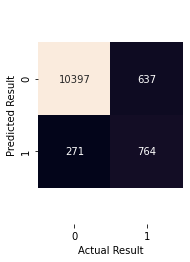

In [213]:
mat = confusion_matrix( y_pred_lr,test_y_lr)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [214]:
predslog = logisticRegression_model.predict_proba(test_X_lr)[:,1]
metrics.roc_auc_score(test_y_lr,predslog, average='macro', sample_weight=None)

0.9463362716705378

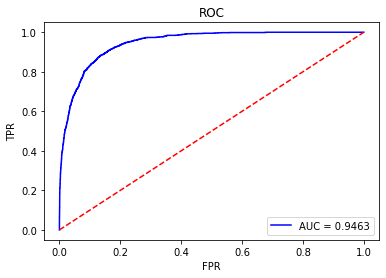

In [215]:
plot_roc(test_y_lr,predslog)

In [216]:
fbwx_w2v_lr_naive_resampling_performance = classification_report(test_y_lr, y_pred_lr,digits=4,output_dict=True)
performance = fbwx_w2v_lr_naive_resampling_performance
model_name = 'fbwx_w2v_LR_naive_resampling'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.932903,0.743590,0.630435,0.682353,1380,0.953220,0.971942,0.962490,10692,0.848405,0.801188,0.822421,12072,0.929256,0.932903,0.930466,12072
TF-IDF_CNN_naive_resampling,0.930417,0.721311,0.637681,0.676923,1380,0.953926,0.968201,0.961010,10692,0.837619,0.802941,0.818967,12072,0.927334,0.930417,0.928535,12072
fbwx_w2v_LR,0.869169,0.784451,0.715895,0.748607,3284,0.897156,0.926466,0.911575,8785,0.840804,0.821180,0.830091,12069,0.866489,0.869169,0.867231,12069
fbwx_w2v_LR_naive_resampling,0.861878,0.779078,0.698532,0.736609,3337,0.889170,0.924301,0.906396,8732,0.834124,0.811417,0.821502,12069,0.858730,0.861878,0.859451,12069
fbwx_w2v_LR,0.925097,0.728115,0.524870,0.610009,1347,0.942332,0.975378,0.958570,10722,0.835224,0.750124,0.784289,12069,0.918424,0.925097,0.919668,12069
fbwx_w2v_LR_naive_resampling,0.924766,0.738164,0.545325,0.627258,1401,0.942269,0.974597,0.958161,10668,0.840217,0.759961,0.792709,12069,0.918576,0.924766,0.919749,12069


In [223]:
performance_df.drop()

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.932903,0.743590,0.630435,0.682353,1380,0.953220,0.971942,0.962490,10692,0.848405,0.801188,0.822421,12072,0.929256,0.932903,0.930466,12072
TF-IDF_CNN_naive_resampling,0.930417,0.721311,0.637681,0.676923,1380,0.953926,0.968201,0.961010,10692,0.837619,0.802941,0.818967,12072,0.927334,0.930417,0.928535,12072
fbwx_w2v_LR,0.925097,0.728115,0.524870,0.610009,1347,0.942332,0.975378,0.958570,10722,0.835224,0.750124,0.784289,12069,0.918424,0.925097,0.919668,12069
fbwx_w2v_LR_naive_resampling,0.924766,0.738164,0.545325,0.627258,1401,0.942269,0.974597,0.958161,10668,0.840217,0.759961,0.792709,12069,0.918576,0.924766,0.919749,12069


### Model 3.1: 现有样本训练Word2Vec + SVM

In [224]:
#训练模型
model_svm = LinearSVC()
train_X_svm, test_X_svm, train_y_svm, test_y_svm = train_test_split(X, y, test_size=0.2)


In [225]:
model_svm.fit(train_X_svm, train_y_svm)
y_pred_svm = model_svm.predict(test_X_svm)

In [226]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.9424    0.9738    0.9578     10710
           1     0.7196    0.5305    0.6108      1359

    accuracy                         0.9239     12069
   macro avg     0.8310    0.7521    0.7843     12069
weighted avg     0.9173    0.9239    0.9187     12069



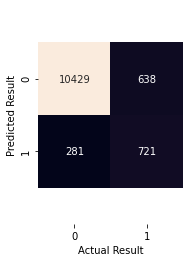

In [227]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [228]:
fbwx_w2v_linear_SVM_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_linear_SVM_performance
model_name = 'fbwx_w2v_linear_SVM'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.932903,0.743590,0.630435,0.682353,1380,0.953220,0.971942,0.962490,10692,0.848405,0.801188,0.822421,12072,0.929256,0.932903,0.930466,12072
TF-IDF_CNN_naive_resampling,0.930417,0.721311,0.637681,0.676923,1380,0.953926,0.968201,0.961010,10692,0.837619,0.802941,0.818967,12072,0.927334,0.930417,0.928535,12072
fbwx_w2v_LR,0.925097,0.728115,0.524870,0.610009,1347,0.942332,0.975378,0.958570,10722,0.835224,0.750124,0.784289,12069,0.918424,0.925097,0.919668,12069
fbwx_w2v_LR_naive_resampling,0.924766,0.738164,0.545325,0.627258,1401,0.942269,0.974597,0.958161,10668,0.840217,0.759961,0.792709,12069,0.918576,0.924766,0.919749,12069
fbwx_w2v_linear_SVM,0.923855,0.719561,0.530537,0.610758,1359,0.942351,0.973763,0.957800,10710,0.830956,0.752150,0.784279,12069,0.917264,0.923855,0.918722,12069


### Model 3.2 现有样本训练Word2Vec + SVM + Naive Resampling

In [229]:
model_svm_sampling = LinearSVC()


In [230]:
X_resampling = np.array(train_X_svm)
y_resampling = train_y_svm
ros = RandomOverSampler(random_state=0)
X_resampled_naive, y_resampled_naive = ros.fit_resample(X_resampling, y_resampling)


In [231]:
model_svm_sampling.fit(X_resampled_naive, y_resampled_naive)
y_pred_svm = model_svm_sampling.predict(test_X_svm)

In [232]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.9835    0.8617    0.9186     10710
           1     0.4484    0.8859    0.5955      1359

    accuracy                         0.8644     12069
   macro avg     0.7159    0.8738    0.7570     12069
weighted avg     0.9232    0.8644    0.8822     12069



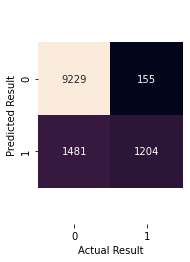

In [233]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [234]:
fbwx_w2v_linear_SVM_naive_resampling_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_linear_SVM_naive_resampling_performance
model_name = 'fbwx_w2v_linear_SVM_naive_resampling'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.932903,0.743590,0.630435,0.682353,1380,0.953220,0.971942,0.962490,10692,0.848405,0.801188,0.822421,12072,0.929256,0.932903,0.930466,12072
TF-IDF_CNN_naive_resampling,0.930417,0.721311,0.637681,0.676923,1380,0.953926,0.968201,0.961010,10692,0.837619,0.802941,0.818967,12072,0.927334,0.930417,0.928535,12072
fbwx_w2v_LR,0.925097,0.728115,0.524870,0.610009,1347,0.942332,0.975378,0.958570,10722,0.835224,0.750124,0.784289,12069,0.918424,0.925097,0.919668,12069
fbwx_w2v_LR_naive_resampling,0.924766,0.738164,0.545325,0.627258,1401,0.942269,0.974597,0.958161,10668,0.840217,0.759961,0.792709,12069,0.918576,0.924766,0.919749,12069
fbwx_w2v_linear_SVM,0.923855,0.719561,0.530537,0.610758,1359,0.942351,0.973763,0.957800,10710,0.830956,0.752150,0.784279,12069,0.917264,0.923855,0.918722,12069
fbwx_w2v_linear_SVM_naive_resampling,0.864446,0.448417,0.885946,0.595450,1359,0.983483,0.861718,0.918583,10710,0.715950,0.873832,0.757016,12069,0.923233,0.864446,0.882197,12069


In [237]:
clf = LinearSVC()
scores = cross_val_score(clf,X_resampled_naive, y_resampled_naive, cv=10)
print(scores)

[0.87972388 0.88253188 0.87748654 0.88415633 0.87900772 0.88263515
 0.87631641 0.87315703 0.87947578 0.87830564]


In [238]:
from sklearn.model_selection import cross_validate


In [244]:
cv_results = cross_validate(clf,
                            X_resampled_naive, y_resampled_naive, 
                            cv=5,
                            scoring=('accuracy', 'roc_auc', 'f1', 'recall'),
                            n_jobs = -1)

In [245]:
cv_results

{'fit_time': array([46.02580595, 45.79501677, 45.66646004, 45.86827278, 45.85397315]),
 'score_time': array([0.04786921, 0.0515821 , 0.0641861 , 0.049227  , 0.05314684]),
 'test_accuracy': array([0.88129644, 0.88006786, 0.88058741, 0.87491224, 0.87842265]),
 'test_roc_auc': array([0.95150321, 0.95161953, 0.95047332, 0.94956902, 0.95061787]),
 'test_f1': array([0.88331704, 0.88230566, 0.88259994, 0.87721112, 0.8807529 ]),
 'test_recall': array([0.89866604, 0.8990289 , 0.89772993, 0.89363445, 0.89796396])}

### Model 3.3 现有样本训练Word2Vec + kernal_SVM

In [246]:
from sklearn.svm import SVC

#### SVC(kernel = 'poly', C = 0.1)

In [247]:
kernal_svm = SVC(kernel = 'poly', C = 0.1)
kernal_svm.fit(train_X_svm,train_y_svm)

SVC(C=0.1, kernel='poly')

In [248]:
y_pred_svm = kernal_svm.predict(test_X_svm)

In [249]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.9223    0.9891    0.9545     10710
           1     0.7997    0.3436    0.4807      1359

    accuracy                         0.9164     12069
   macro avg     0.8610    0.6664    0.7176     12069
weighted avg     0.9085    0.9164    0.9012     12069



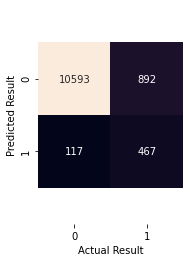

In [250]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [251]:
fbwx_w2v_poly_SVM_C0_1_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_poly_SVM_C0_1_performance
model_name = 'fbwx_w2v_poly_SVM C=0.1'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df


,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.932903,0.743590,0.630435,0.682353,1380,0.953220,0.971942,0.962490,10692,0.848405,0.801188,0.822421,12072,0.929256,0.932903,0.930466,12072
TF-IDF_CNN_naive_resampling,0.930417,0.721311,0.637681,0.676923,1380,0.953926,0.968201,0.961010,10692,0.837619,0.802941,0.818967,12072,0.927334,0.930417,0.928535,12072
fbwx_w2v_LR,0.925097,0.728115,0.524870,0.610009,1347,0.942332,0.975378,0.958570,10722,0.835224,0.750124,0.784289,12069,0.918424,0.925097,0.919668,12069
fbwx_w2v_LR_naive_resampling,0.924766,0.738164,0.545325,0.627258,1401,0.942269,0.974597,0.958161,10668,0.840217,0.759961,0.792709,12069,0.918576,0.924766,0.919749,12069
fbwx_w2v_linear_SVM,0.923855,0.719561,0.530537,0.610758,1359,0.942351,0.973763,0.957800,10710,0.830956,0.752150,0.784279,12069,0.917264,0.923855,0.918722,12069
fbwx_w2v_linear_SVM_naive_resampling,0.864446,0.448417,0.885946,0.595450,1359,0.983483,0.861718,0.918583,10710,0.715950,0.873832,0.757016,12069,0.923233,0.864446,0.882197,12069
fbwx_w2v_poly_SVM C=0.1,0.916397,0.799658,0.343635,0.480700,1359,0.922333,0.989076,0.954539,10710,0.860996,0.666355,0.717620,12069,0.908520,0.916397,0.901184,12069


#### kernal_svm = SVC(kernel = 'poly', C = 1)

In [252]:
kernal_svm = SVC(kernel = 'poly', C = 1)
kernal_svm.fit(train_X_svm,train_y_svm)

SVC(C=1, kernel='poly')

In [253]:
y_pred_svm = kernal_svm.predict(test_X_svm)

In [254]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.9388    0.9841    0.9609     10710
           1     0.7981    0.4945    0.6106      1359

    accuracy                         0.9290     12069
   macro avg     0.8685    0.7393    0.7858     12069
weighted avg     0.9230    0.9290    0.9215     12069



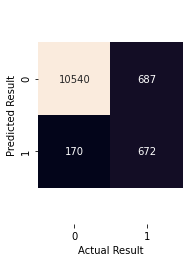

In [255]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [256]:
fbwx_w2v_poly_SVM_C1_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_poly_SVM_C1_performance
model_name = 'fbwx_w2v_poly_SVM C=1'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.932903,0.743590,0.630435,0.682353,1380,0.953220,0.971942,0.962490,10692,0.848405,0.801188,0.822421,12072,0.929256,0.932903,0.930466,12072
TF-IDF_CNN_naive_resampling,0.930417,0.721311,0.637681,0.676923,1380,0.953926,0.968201,0.961010,10692,0.837619,0.802941,0.818967,12072,0.927334,0.930417,0.928535,12072
fbwx_w2v_LR,0.925097,0.728115,0.524870,0.610009,1347,0.942332,0.975378,0.958570,10722,0.835224,0.750124,0.784289,12069,0.918424,0.925097,0.919668,12069
fbwx_w2v_LR_naive_resampling,0.924766,0.738164,0.545325,0.627258,1401,0.942269,0.974597,0.958161,10668,0.840217,0.759961,0.792709,12069,0.918576,0.924766,0.919749,12069
fbwx_w2v_linear_SVM,0.923855,0.719561,0.530537,0.610758,1359,0.942351,0.973763,0.957800,10710,0.830956,0.752150,0.784279,12069,0.917264,0.923855,0.918722,12069
fbwx_w2v_linear_SVM_naive_resampling,0.864446,0.448417,0.885946,0.595450,1359,0.983483,0.861718,0.918583,10710,0.715950,0.873832,0.757016,12069,0.923233,0.864446,0.882197,12069
fbwx_w2v_poly_SVM C=0.1,0.916397,0.799658,0.343635,0.480700,1359,0.922333,0.989076,0.954539,10710,0.860996,0.666355,0.717620,12069,0.908520,0.916397,0.901184,12069
fbwx_w2v_poly_SVM C=1,0.928992,0.798100,0.494481,0.610632,1359,0.938808,0.984127,0.960934,10710,0.868454,0.739304,0.785783,12069,0.922964,0.928992,0.921489,12069


### Model 3.4 现有样本训练Word2Vec + kernal_SVM + Naive Resampling
* 可能是做了不平衡处理的原因，模型更偏向于预测样本为负类。不过也不算一件坏事。recall得以提升，代价是降低的precision。模型更为贪婪。
    * recall高：宁错杀不放过
    * precision高：不冤枉好人
* 样本增加 调整参数C的值。C = 1 的表现由于 C = 0.1

In [257]:
X_resampling = np.array(train_X_svm)
y_resampling = train_y_svm
ros = RandomOverSampler(random_state=0)
X_resampled_naive, y_resampled_naive = ros.fit_resample(X_resampling, y_resampling)


#### kernal_svm = SVC(kernel = 'poly', C = 0.1)

In [258]:
kernal_svm = SVC(kernel = 'poly', C = 0.1)
kernal_svm.fit(X_resampled_naive,y_resampled_naive)

SVC(C=0.1, kernel='poly')

In [259]:
y_pred_svm = kernal_svm.predict(test_X_svm)

In [260]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.9829    0.8712    0.9237     10710
           1     0.4647    0.8808    0.6084      1359

    accuracy                         0.8723     12069
   macro avg     0.7238    0.8760    0.7661     12069
weighted avg     0.9246    0.8723    0.8882     12069



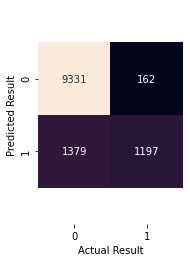

In [261]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim()
a += 0.5 
b -= 0.5 
plt.ylim(a, b)
plt.show()

In [262]:
fbwx_w2v_poly_SVM_C0_1_naive_resampling_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_poly_SVM_C0_1_naive_resampling_performance
model_name = 'fbwx_w2v_poly_SVM(C=0.1)_naive_resampling'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df


,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.932903,0.743590,0.630435,0.682353,1380,0.953220,0.971942,0.962490,10692,0.848405,0.801188,0.822421,12072,0.929256,0.932903,0.930466,12072
TF-IDF_CNN_naive_resampling,0.930417,0.721311,0.637681,0.676923,1380,0.953926,0.968201,0.961010,10692,0.837619,0.802941,0.818967,12072,0.927334,0.930417,0.928535,12072
fbwx_w2v_LR,0.925097,0.728115,0.524870,0.610009,1347,0.942332,0.975378,0.958570,10722,0.835224,0.750124,0.784289,12069,0.918424,0.925097,0.919668,12069
fbwx_w2v_LR_naive_resampling,0.924766,0.738164,0.545325,0.627258,1401,0.942269,0.974597,0.958161,10668,0.840217,0.759961,0.792709,12069,0.918576,0.924766,0.919749,12069
fbwx_w2v_linear_SVM,0.923855,0.719561,0.530537,0.610758,1359,0.942351,0.973763,0.957800,10710,0.830956,0.752150,0.784279,12069,0.917264,0.923855,0.918722,12069
fbwx_w2v_linear_SVM_naive_resampling,0.864446,0.448417,0.885946,0.595450,1359,0.983483,0.861718,0.918583,10710,0.715950,0.873832,0.757016,12069,0.923233,0.864446,0.882197,12069
fbwx_w2v_poly_SVM C=0.1,0.916397,0.799658,0.343635,0.480700,1359,0.922333,0.989076,0.954539,10710,0.860996,0.666355,0.717620,12069,0.908520,0.916397,0.901184,12069
fbwx_w2v_poly_SVM C=1,0.928992,0.798100,0.494481,0.610632,1359,0.938808,0.984127,0.960934,10710,0.868454,0.739304,0.785783,12069,0.922964,0.928992,0.921489,12069
fbwx_w2v_poly_SVM(C=0.1)_naive_resampling,0.872318,0.464674,0.880795,0.608386,1359,0.982935,0.871242,0.923724,10710,0.723804,0.876018,0.766055,12069,0.924577,0.872318,0.888216,12069


#### kernal_svm = SVC(kernel = 'poly', C = 1)


In [263]:
kernal_svm = SVC(kernel = 'poly', C = 1)
kernal_svm.fit(X_resampled_naive,y_resampled_naive)

SVC(C=1, kernel='poly')

In [264]:
y_pred_svm = kernal_svm.predict(test_X_svm)

In [265]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.9823    0.8946    0.9364     10710
           1     0.5123    0.8727    0.6456      1359

    accuracy                         0.8921     12069
   macro avg     0.7473    0.8836    0.7910     12069
weighted avg     0.9293    0.8921    0.9036     12069



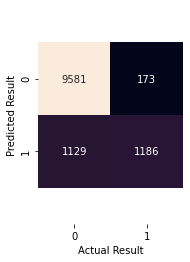

In [266]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [267]:
fbwx_w2v_poly_SVM_C1_naive_resampling_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_poly_SVM_C1_naive_resampling_performance
model_name = 'fbwx_w2v_poly_SVM(C=1)_naive_resampling'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.932903,0.743590,0.630435,0.682353,1380,0.953220,0.971942,0.962490,10692,0.848405,0.801188,0.822421,12072,0.929256,0.932903,0.930466,12072
TF-IDF_CNN_naive_resampling,0.930417,0.721311,0.637681,0.676923,1380,0.953926,0.968201,0.961010,10692,0.837619,0.802941,0.818967,12072,0.927334,0.930417,0.928535,12072
fbwx_w2v_LR,0.925097,0.728115,0.524870,0.610009,1347,0.942332,0.975378,0.958570,10722,0.835224,0.750124,0.784289,12069,0.918424,0.925097,0.919668,12069
fbwx_w2v_LR_naive_resampling,0.924766,0.738164,0.545325,0.627258,1401,0.942269,0.974597,0.958161,10668,0.840217,0.759961,0.792709,12069,0.918576,0.924766,0.919749,12069
fbwx_w2v_linear_SVM,0.923855,0.719561,0.530537,0.610758,1359,0.942351,0.973763,0.957800,10710,0.830956,0.752150,0.784279,12069,0.917264,0.923855,0.918722,12069
fbwx_w2v_linear_SVM_naive_resampling,0.864446,0.448417,0.885946,0.595450,1359,0.983483,0.861718,0.918583,10710,0.715950,0.873832,0.757016,12069,0.923233,0.864446,0.882197,12069
fbwx_w2v_poly_SVM C=0.1,0.916397,0.799658,0.343635,0.480700,1359,0.922333,0.989076,0.954539,10710,0.860996,0.666355,0.717620,12069,0.908520,0.916397,0.901184,12069
fbwx_w2v_poly_SVM C=1,0.928992,0.798100,0.494481,0.610632,1359,0.938808,0.984127,0.960934,10710,0.868454,0.739304,0.785783,12069,0.922964,0.928992,0.921489,12069
fbwx_w2v_poly_SVM(C=0.1)_naive_resampling,0.872318,0.464674,0.880795,0.608386,1359,0.982935,0.871242,0.923724,10710,0.723804,0.876018,0.766055,12069,0.924577,0.872318,0.888216,12069
fbwx_w2v_poly_SVM(C=1)_naive_resampling,0.892120,0.512311,0.872701,0.645618,1359,0.982264,0.894585,0.936376,10710,0.747287,0.883643,0.790997,12069,0.929346,0.892120,0.903636,12069


### Model 3.5 现有样本训练Word2Vec + RBF_SVM 
rbf SVM 有较大的提升
计算时间太长，一个模型跑了30+ min

In [268]:
rbf_svm = SVC(C=1.0, kernel='rbf', gamma=0.1)
rbf_svm.fit(train_X_svm,train_y_svm)

SVC(gamma=0.1)

In [269]:
y_pred_svm = rbf_svm.predict(test_X_svm)

In [270]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.9461    0.9775    0.9615     10710
           1     0.7597    0.5607    0.6452      1359

    accuracy                         0.9306     12069
   macro avg     0.8529    0.7691    0.8034     12069
weighted avg     0.9251    0.9306    0.9259     12069



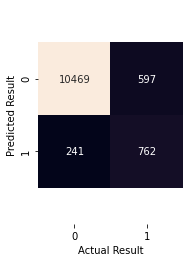

In [271]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [272]:
fbwx_w2v_rbf_SVM_gm0_1_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_rbf_SVM_gm0_1_performance
model_name = 'fbwx_w2v_rbf_SVM(gamma=0.1)'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df


,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.932903,0.743590,0.630435,0.682353,1380,0.953220,0.971942,0.962490,10692,0.848405,0.801188,0.822421,12072,0.929256,0.932903,0.930466,12072
TF-IDF_CNN_naive_resampling,0.930417,0.721311,0.637681,0.676923,1380,0.953926,0.968201,0.961010,10692,0.837619,0.802941,0.818967,12072,0.927334,0.930417,0.928535,12072
fbwx_w2v_LR,0.925097,0.728115,0.524870,0.610009,1347,0.942332,0.975378,0.958570,10722,0.835224,0.750124,0.784289,12069,0.918424,0.925097,0.919668,12069
fbwx_w2v_LR_naive_resampling,0.924766,0.738164,0.545325,0.627258,1401,0.942269,0.974597,0.958161,10668,0.840217,0.759961,0.792709,12069,0.918576,0.924766,0.919749,12069
fbwx_w2v_linear_SVM,0.923855,0.719561,0.530537,0.610758,1359,0.942351,0.973763,0.957800,10710,0.830956,0.752150,0.784279,12069,0.917264,0.923855,0.918722,12069
fbwx_w2v_linear_SVM_naive_resampling,0.864446,0.448417,0.885946,0.595450,1359,0.983483,0.861718,0.918583,10710,0.715950,0.873832,0.757016,12069,0.923233,0.864446,0.882197,12069
fbwx_w2v_poly_SVM C=0.1,0.916397,0.799658,0.343635,0.480700,1359,0.922333,0.989076,0.954539,10710,0.860996,0.666355,0.717620,12069,0.908520,0.916397,0.901184,12069
fbwx_w2v_poly_SVM C=1,0.928992,0.798100,0.494481,0.610632,1359,0.938808,0.984127,0.960934,10710,0.868454,0.739304,0.785783,12069,0.922964,0.928992,0.921489,12069
fbwx_w2v_poly_SVM(C=0.1)_naive_resampling,0.872318,0.464674,0.880795,0.608386,1359,0.982935,0.871242,0.923724,10710,0.723804,0.876018,0.766055,12069,0.924577,0.872318,0.888216,12069
fbwx_w2v_poly_SVM(C=1)_naive_resampling,0.892120,0.512311,0.872701,0.645618,1359,0.982264,0.894585,0.936376,10710,0.747287,0.883643,0.790997,12069,0.929346,0.892120,0.903636,12069


### Model 3.6 现有样本训练Word2Vec + RBF_SVM + Naive Resampling

In [273]:
rbf_svm = SVC(C=1.0, kernel='rbf', gamma=0.1)
rbf_svm.fit(X_resampled_naive,y_resampled_naive)

SVC(gamma=0.1)

In [274]:
y_pred_svm = rbf_svm.predict(test_X_svm)

In [275]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.9721    0.9325    0.9519     10710
           1     0.5972    0.7888    0.6798      1359

    accuracy                         0.9163     12069
   macro avg     0.7846    0.8607    0.8158     12069
weighted avg     0.9299    0.9163    0.9212     12069



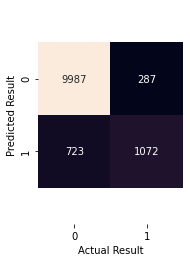

In [276]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [277]:
fbwx_w2v_rbf_SVM_gm0_1_naive_resampling_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_rbf_SVM_gm0_1_naive_resampling_performance
model_name = 'fbwx_w2v_rbf_SVM(gamma=0.1)_naive_resampling'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.932903,0.743590,0.630435,0.682353,1380,0.953220,0.971942,0.962490,10692,0.848405,0.801188,0.822421,12072,0.929256,0.932903,0.930466,12072
TF-IDF_CNN_naive_resampling,0.930417,0.721311,0.637681,0.676923,1380,0.953926,0.968201,0.961010,10692,0.837619,0.802941,0.818967,12072,0.927334,0.930417,0.928535,12072
fbwx_w2v_LR,0.925097,0.728115,0.524870,0.610009,1347,0.942332,0.975378,0.958570,10722,0.835224,0.750124,0.784289,12069,0.918424,0.925097,0.919668,12069
fbwx_w2v_LR_naive_resampling,0.924766,0.738164,0.545325,0.627258,1401,0.942269,0.974597,0.958161,10668,0.840217,0.759961,0.792709,12069,0.918576,0.924766,0.919749,12069
fbwx_w2v_linear_SVM,0.923855,0.719561,0.530537,0.610758,1359,0.942351,0.973763,0.957800,10710,0.830956,0.752150,0.784279,12069,0.917264,0.923855,0.918722,12069
fbwx_w2v_linear_SVM_naive_resampling,0.864446,0.448417,0.885946,0.595450,1359,0.983483,0.861718,0.918583,10710,0.715950,0.873832,0.757016,12069,0.923233,0.864446,0.882197,12069
fbwx_w2v_poly_SVM C=0.1,0.916397,0.799658,0.343635,0.480700,1359,0.922333,0.989076,0.954539,10710,0.860996,0.666355,0.717620,12069,0.908520,0.916397,0.901184,12069
fbwx_w2v_poly_SVM C=1,0.928992,0.798100,0.494481,0.610632,1359,0.938808,0.984127,0.960934,10710,0.868454,0.739304,0.785783,12069,0.922964,0.928992,0.921489,12069
fbwx_w2v_poly_SVM(C=0.1)_naive_resampling,0.872318,0.464674,0.880795,0.608386,1359,0.982935,0.871242,0.923724,10710,0.723804,0.876018,0.766055,12069,0.924577,0.872318,0.888216,12069
fbwx_w2v_poly_SVM(C=1)_naive_resampling,0.892120,0.512311,0.872701,0.645618,1359,0.982264,0.894585,0.936376,10710,0.747287,0.883643,0.790997,12069,0.929346,0.892120,0.903636,12069


### Model 3.7 现有样本训练Word2Vec + RBF_SVM + gamma = 1/k

In [278]:
startTime = time.time()
rbf_svm = SVC(kernel='rbf')
rbf_svm.fit(train_X_svm,train_y_svm)
usedTime = time.time() - startTime

In [279]:
print(usedTime)

162.2042260169983


In [280]:
y_pred_svm = rbf_svm.predict(test_X_svm)

In [281]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.9441    0.9775    0.9605     10710
           1     0.7541    0.5438    0.6319      1359

    accuracy                         0.9287     12069
   macro avg     0.8491    0.7606    0.7962     12069
weighted avg     0.9227    0.9287    0.9235     12069



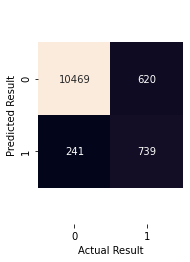

In [282]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [283]:
fbwx_w2v_rbf_SVM_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_rbf_SVM_performance
model_name = 'fbwx_w2v_rbf_SVM(gamma=1/k)'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df


,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.932903,0.743590,0.630435,0.682353,1380,0.953220,0.971942,0.962490,10692,0.848405,0.801188,0.822421,12072,0.929256,0.932903,0.930466,12072
TF-IDF_CNN_naive_resampling,0.930417,0.721311,0.637681,0.676923,1380,0.953926,0.968201,0.961010,10692,0.837619,0.802941,0.818967,12072,0.927334,0.930417,0.928535,12072
fbwx_w2v_LR,0.925097,0.728115,0.524870,0.610009,1347,0.942332,0.975378,0.958570,10722,0.835224,0.750124,0.784289,12069,0.918424,0.925097,0.919668,12069
fbwx_w2v_LR_naive_resampling,0.924766,0.738164,0.545325,0.627258,1401,0.942269,0.974597,0.958161,10668,0.840217,0.759961,0.792709,12069,0.918576,0.924766,0.919749,12069
fbwx_w2v_linear_SVM,0.923855,0.719561,0.530537,0.610758,1359,0.942351,0.973763,0.957800,10710,0.830956,0.752150,0.784279,12069,0.917264,0.923855,0.918722,12069
fbwx_w2v_linear_SVM_naive_resampling,0.864446,0.448417,0.885946,0.595450,1359,0.983483,0.861718,0.918583,10710,0.715950,0.873832,0.757016,12069,0.923233,0.864446,0.882197,12069
fbwx_w2v_poly_SVM C=0.1,0.916397,0.799658,0.343635,0.480700,1359,0.922333,0.989076,0.954539,10710,0.860996,0.666355,0.717620,12069,0.908520,0.916397,0.901184,12069
fbwx_w2v_poly_SVM C=1,0.928992,0.798100,0.494481,0.610632,1359,0.938808,0.984127,0.960934,10710,0.868454,0.739304,0.785783,12069,0.922964,0.928992,0.921489,12069
fbwx_w2v_poly_SVM(C=0.1)_naive_resampling,0.872318,0.464674,0.880795,0.608386,1359,0.982935,0.871242,0.923724,10710,0.723804,0.876018,0.766055,12069,0.924577,0.872318,0.888216,12069
fbwx_w2v_poly_SVM(C=1)_naive_resampling,0.892120,0.512311,0.872701,0.645618,1359,0.982264,0.894585,0.936376,10710,0.747287,0.883643,0.790997,12069,0.929346,0.892120,0.903636,12069


### Model 3.8 现有样本训练Word2Vec + RBF_SVM + gamma = 1/k + Naive Resampling

In [284]:
startTime = time.time()
rbf_svm = SVC(kernel='rbf')
rbf_svm.fit(X_resampled_naive,y_resampled_naive)
usedTime = time.time() - startTime

In [285]:
print(usedTime)

801.4588947296143


In [286]:
y_pred_svm = rbf_svm.predict(test_X_svm)

In [287]:
print(classification_report(test_y_svm, y_pred_svm,digits=4))

              precision    recall  f1-score   support

           0     0.9837    0.8880    0.9334     10710
           1     0.5004    0.8837    0.6390      1359

    accuracy                         0.8876     12069
   macro avg     0.7420    0.8859    0.7862     12069
weighted avg     0.9292    0.8876    0.9003     12069



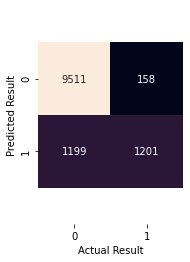

In [288]:
mat = confusion_matrix( y_pred_svm,test_y_svm)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [289]:
fbwx_w2v_rbf_SVM_naive_resampling_performance = classification_report(test_y_svm, y_pred_svm,digits=4,output_dict=True)
performance = fbwx_w2v_rbf_SVM_naive_resampling_performance
model_name = 'fbwx_w2v_rbf_SVM(gamma=1/k)_naive_resampling'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.932903,0.743590,0.630435,0.682353,1380,0.953220,0.971942,0.962490,10692,0.848405,0.801188,0.822421,12072,0.929256,0.932903,0.930466,12072
TF-IDF_CNN_naive_resampling,0.930417,0.721311,0.637681,0.676923,1380,0.953926,0.968201,0.961010,10692,0.837619,0.802941,0.818967,12072,0.927334,0.930417,0.928535,12072
fbwx_w2v_LR,0.925097,0.728115,0.524870,0.610009,1347,0.942332,0.975378,0.958570,10722,0.835224,0.750124,0.784289,12069,0.918424,0.925097,0.919668,12069
fbwx_w2v_LR_naive_resampling,0.924766,0.738164,0.545325,0.627258,1401,0.942269,0.974597,0.958161,10668,0.840217,0.759961,0.792709,12069,0.918576,0.924766,0.919749,12069
fbwx_w2v_linear_SVM,0.923855,0.719561,0.530537,0.610758,1359,0.942351,0.973763,0.957800,10710,0.830956,0.752150,0.784279,12069,0.917264,0.923855,0.918722,12069
fbwx_w2v_linear_SVM_naive_resampling,0.864446,0.448417,0.885946,0.595450,1359,0.983483,0.861718,0.918583,10710,0.715950,0.873832,0.757016,12069,0.923233,0.864446,0.882197,12069
fbwx_w2v_poly_SVM C=0.1,0.916397,0.799658,0.343635,0.480700,1359,0.922333,0.989076,0.954539,10710,0.860996,0.666355,0.717620,12069,0.908520,0.916397,0.901184,12069
fbwx_w2v_poly_SVM C=1,0.928992,0.798100,0.494481,0.610632,1359,0.938808,0.984127,0.960934,10710,0.868454,0.739304,0.785783,12069,0.922964,0.928992,0.921489,12069
fbwx_w2v_poly_SVM(C=0.1)_naive_resampling,0.872318,0.464674,0.880795,0.608386,1359,0.982935,0.871242,0.923724,10710,0.723804,0.876018,0.766055,12069,0.924577,0.872318,0.888216,12069
fbwx_w2v_poly_SVM(C=1)_naive_resampling,0.892120,0.512311,0.872701,0.645618,1359,0.982264,0.894585,0.936376,10710,0.747287,0.883643,0.790997,12069,0.929346,0.892120,0.903636,12069


### Model 4.1 现有样本训练Word2Vec + XGBoost

In [626]:
import xgboost as xgb

In [627]:
train_X_xgb = train_X_svm.copy()
test_X_xgb = test_X_svm.copy()
train_y_xgb = train_y_svm.copy()
test_y_xgb = test_y_svm.copy()

In [628]:
train_X_xgb.shape

(48273, 200)

In [629]:
params={
'booster':'gbtree', 
# 这里手写数字是0-9，是一个多类的问题，因此采用了multisoft多分类器，
'objective': 'binary:logistic',  #二分类的逻辑回归问题，输出为概率
'eval_metric' : 'auc',
'gamma':0.05,  # 在树的叶子节点下一个分区的最小损失，越大算法模型越保守 。[0:]
'n_estimators' : 10,
'max_depth':4, # 构建树的深度 [1:] 需要用单颗树较少的深度来减少偏差 一般3-10 这里调低深度使得模型更为贪婪
#'lambda':450,  # L2 正则项权重
'subsample':0.7, # 采样训练数据，设置为0.5，随机选择一般的数据实例 (0:1]
'colsample_bytree':0.7, # 构建树树时的采样比率 (0:1]
#'min_child_weight':12, # 节点的最少特征数
'scale_pos_weight' : 2.349911190053286,
'silent':0 ,
'eta': 0.05, # 如同学习率http://localhost:8889/notebooks/Test.ipynb#
'seed':701,
'nthreads':-1,# cpu 线程数,根据自己U的个数适当调整
}

In [636]:
word2vec_gb_wx.label.value_counts()

0    43770
1    16572
Name: label, dtype: int64

In [637]:
sklearn_model_new = xgb.XGBClassifier(max_depth=5,
                                      learning_rate= 0.05, #0.0001到0.1之间 太小速度很慢
                                      verbosity=1, 
                                      objective='binary:logistic',
                                      subsample = 0.7,
                                      colsample_bytree = 0.7,
                                      scale_pos_weight = 43770/16572,
                                      random_state=1
                                     # 这里没有用到n_estimator, 因为用early_stopping_rounds使得auc最优)

In [638]:
train_X_xgb, val_X_xgb, train_y_xgb, val_y_xgb = train_test_split(X, y, test_size=0.05)

In [639]:
sklearn_model_new.fit(train_X_xgb, train_y_xgb, early_stopping_rounds=10, eval_metric="auc",
        eval_set=[(val_X_xgb, val_y_xgb)])

[0]	validation_0-auc:0.834877
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.87369
[2]	validation_0-auc:0.877923
[3]	validation_0-auc:0.883487
[4]	validation_0-auc:0.885268
[5]	validation_0-auc:0.887156
[6]	validation_0-auc:0.888427
[7]	validation_0-auc:0.888421
[8]	validation_0-auc:0.8882
[9]	validation_0-auc:0.888612
[10]	validation_0-auc:0.889117
[11]	validation_0-auc:0.890345
[12]	validation_0-auc:0.891183
[13]	validation_0-auc:0.891934
[14]	validation_0-auc:0.892814
[15]	validation_0-auc:0.893858
[16]	validation_0-auc:0.894098
[17]	validation_0-auc:0.894823
[18]	validation_0-auc:0.895078
[19]	validation_0-auc:0.895482
[20]	validation_0-auc:0.895415
[21]	validation_0-auc:0.896357
[22]	validation_0-auc:0.897197
[23]	validation_0-auc:0.897998
[24]	validation_0-auc:0.898762
[25]	validation_0-auc:0.899002
[26]	validation_0-auc:0.899427
[27]	validation_0-auc:0.899916
[28]	validation_0-auc:0.900265
[29]	validation_0-auc:0.900666
[30]	validation_0-a

XGBClassifier(colsample_bytree=0.7, learning_rate=0.05, max_depth=5,
              random_state=1, scale_pos_weight=2.6412020275162926,
              subsample=0.7)

In [640]:
y_pred_xgb = sklearn_model_new.predict(test_X_xgb)

In [641]:
print(classification_report(test_y_xgb, y_pred_xgb,digits=4))

              precision    recall  f1-score   support

           0     0.9492    0.8237    0.8820      8716
           1     0.6589    0.8855    0.7556      3353

    accuracy                         0.8408     12069
   macro avg     0.8041    0.8546    0.8188     12069
weighted avg     0.8686    0.8408    0.8469     12069



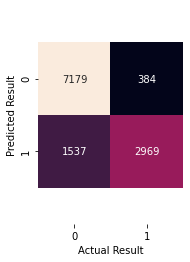

In [642]:
mat = confusion_matrix(y_pred_xgb,test_y_xgb)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [266]:
from sklearn.model_selection import GridSearchCV

In [332]:
paramGrid = {"max_depth" : [5,6,7,8,9,10]}
cv = 2

In [333]:
fit_params={"early_stopping_rounds":5, 
            "eval_metric" : "auc", 
            "eval_set" : [[val_X_xgb, val_y_xgb]]}

In [334]:
model = xgb.XGBRegressor(learning_rate= 0.05, 
                         verbosity=1,
                         objective='binary:logistic',
                         subsample = 0.7,
                         colsample_bytree = 0.7,
                         scale_pos_weight = 2.349911190053286,
                         random_state=1)

gridsearch = GridSearchCV(model, paramGrid, verbose=1,cv = 2,
                        n_jobs = -1)

gridsearch.fit(train_X_xgb, train_y_xgb, **fit_params)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.3min remaining:   15.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.0min finished


[0]	validation_0-auc:0.862506
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.883963
[2]	validation_0-auc:0.892269
[3]	validation_0-auc:0.899534
[4]	validation_0-auc:0.902337
[5]	validation_0-auc:0.905057
[6]	validation_0-auc:0.907803
[7]	validation_0-auc:0.908734
[8]	validation_0-auc:0.907833
[9]	validation_0-auc:0.9092
[10]	validation_0-auc:0.91059
[11]	validation_0-auc:0.911343
[12]	validation_0-auc:0.911638
[13]	validation_0-auc:0.91207
[14]	validation_0-auc:0.912862
[15]	validation_0-auc:0.913734
[16]	validation_0-auc:0.914234
[17]	validation_0-auc:0.91447
[18]	validation_0-auc:0.915312
[19]	validation_0-auc:0.91593
[20]	validation_0-auc:0.916336
[21]	validation_0-auc:0.917199
[22]	validation_0-auc:0.917462
[23]	validation_0-auc:0.917856
[24]	validation_0-auc:0.918561
[25]	validation_0-auc:0.918727
[26]	validation_0-auc:0.919605
[27]	validation_0-auc:0.920208
[28]	validation_0-auc:0.920403
[29]	validation_0-auc:0.921049
[30]	validation_0-auc:0

GridSearchCV(cv=2,
             estimator=XGBRegressor(colsample_bytree=0.7, learning_rate=0.05,
                                    objective='binary:logistic', random_state=1,
                                    scale_pos_weight=2.349911190053286,
                                    subsample=0.7),
             n_jobs=-1, param_grid={'max_depth': [5, 6, 7, 8, 9, 10]},
             verbose=1)

In [335]:
print(gridsearch.best_score_)
print(gridsearch.best_params_)

0.5112642258986644
{'max_depth': 9}


In [336]:
model = xgb.XGBRegressor(learning_rate= 0.05, 
                         verbosity=1,
                         objective='binary:logistic',
                         subsample = 0.7,
                         colsample_bytree = 0.7,
                         scale_pos_weight = 2.349911190053286,
                         random_state=1,
                        max_depth = 5)
model.fit(train_X_xgb, train_y_xgb, early_stopping_rounds=10, eval_metric="auc",
        eval_set=[(val_X_xgb, val_y_xgb)])
y_pred_xgb = model.predict(test_X_xgb)

[0]	validation_0-auc:0.849186
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.878202
[2]	validation_0-auc:0.877414
[3]	validation_0-auc:0.880505
[4]	validation_0-auc:0.883067
[5]	validation_0-auc:0.885838
[6]	validation_0-auc:0.888724
[7]	validation_0-auc:0.890981
[8]	validation_0-auc:0.891121
[9]	validation_0-auc:0.892434
[10]	validation_0-auc:0.893584
[11]	validation_0-auc:0.894864
[12]	validation_0-auc:0.895439
[13]	validation_0-auc:0.895722
[14]	validation_0-auc:0.895696
[15]	validation_0-auc:0.89571
[16]	validation_0-auc:0.89603
[17]	validation_0-auc:0.897556
[18]	validation_0-auc:0.898382
[19]	validation_0-auc:0.898597
[20]	validation_0-auc:0.899176
[21]	validation_0-auc:0.899345
[22]	validation_0-auc:0.899867
[23]	validation_0-auc:0.899843
[24]	validation_0-auc:0.900845
[25]	validation_0-auc:0.901522
[26]	validation_0-auc:0.90233
[27]	validation_0-auc:0.90262
[28]	validation_0-auc:0.903502
[29]	validation_0-auc:0.904483
[30]	validation_0-au

In [337]:
y_pred_xgb_label = []
for i in y_pred_xgb:
    if i >= 0.5:
        label = 1
        y_pred_xgb_label.append(label)
    else:
        label = 0
        y_pred_xgb_label.append(label)


In [338]:
print(classification_report(test_y_xgb, y_pred_xgb_label,digits=4))

              precision    recall  f1-score   support

           0     0.9467    0.8357    0.8878      4974
           1     0.6954    0.8885    0.7802      2099

    accuracy                         0.8514      7073
   macro avg     0.8210    0.8621    0.8340      7073
weighted avg     0.8721    0.8514    0.8558      7073



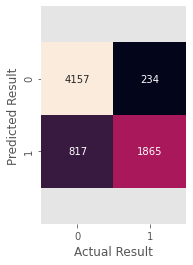

In [339]:
mat = confusion_matrix(y_pred_xgb_label,test_y_xgb)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [643]:
from xgboost import XGBClassifier
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [650]:
model = XGBClassifier(max_depth = 5,
                      learning_rate = 0.05,
                      n_estimators = 200,
                      colsample_bytree = 0.7,
                      subsample = 0.7,
                      scale_pos_weight =43770/16572,
                     random_state = 1)
eval_set = [(train_X_xgb, train_y_xgb), (val_X_xgb, val_y_xgb)]
model.fit(train_X_xgb, train_y_xgb, eval_metric=["error", "logloss",'auc'], eval_set=eval_set, verbose=False)

XGBClassifier(colsample_bytree=0.7, learning_rate=0.05, max_depth=5,
              n_estimators=200, random_state=1,
              scale_pos_weight=2.6412020275162926, subsample=0.7)

In [651]:
y_pred = model.predict(test_X_xgb)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(test_y_xgb, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
results = model.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

Accuracy: 87.05%


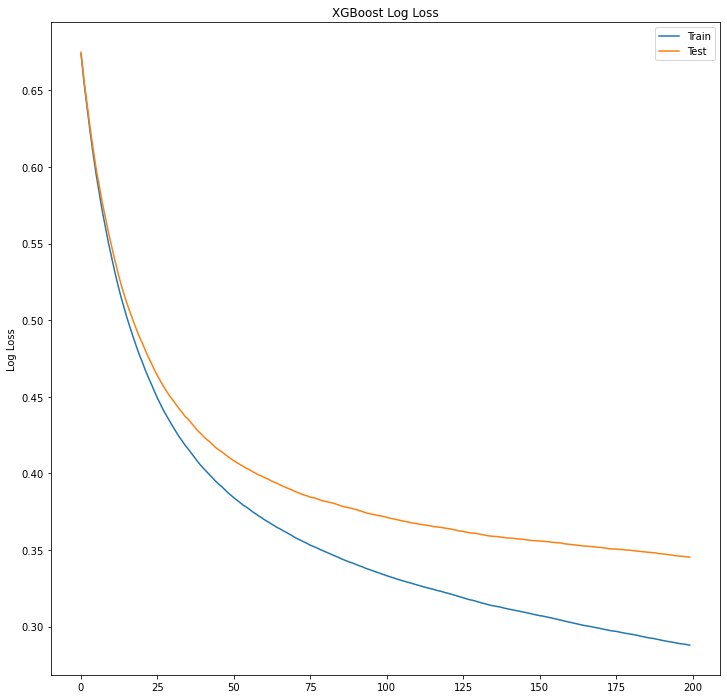

In [652]:
# plot log loss
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
pyplot.ylabel("Log Loss")
pyplot.title("XGBoost Log Loss")
pyplot.show()

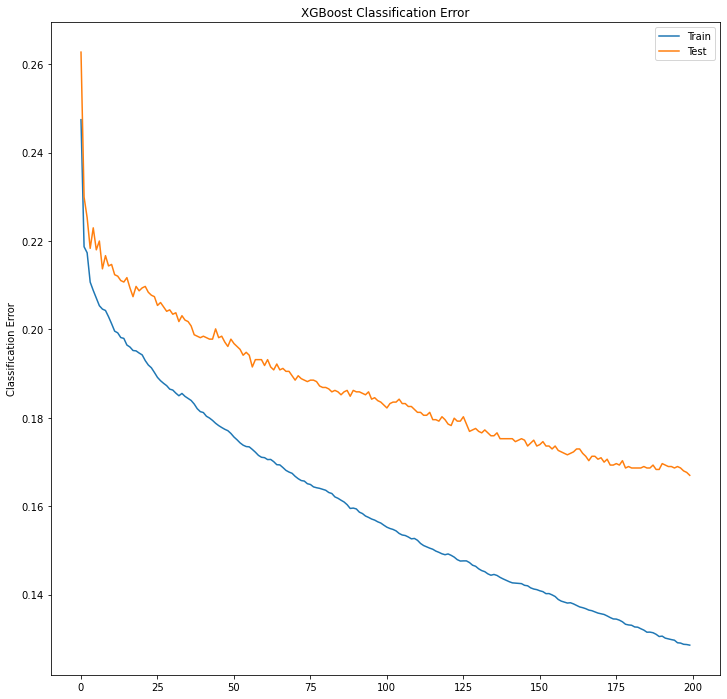

In [653]:
# plot classification error
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
pyplot.ylabel("Classification Error")
pyplot.title("XGBoost Classification Error")
pyplot.show()

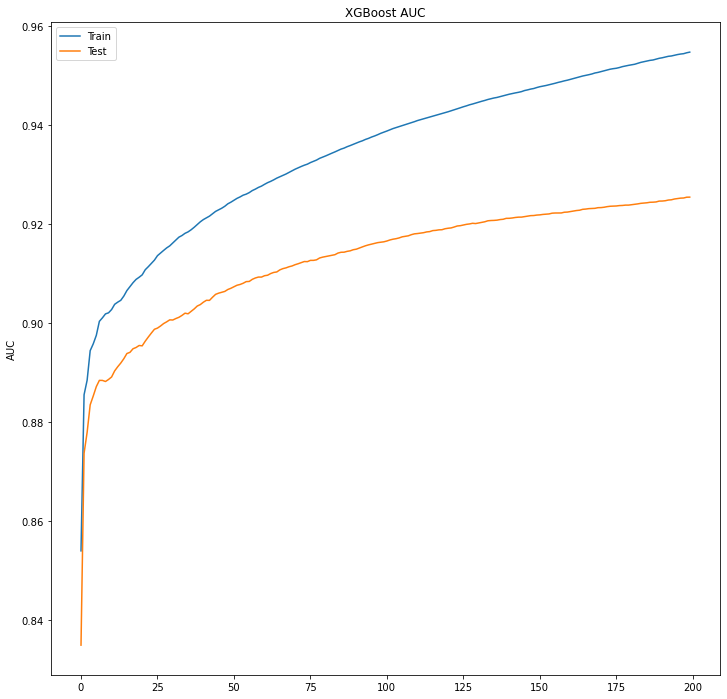

In [654]:
# plot log loss
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["auc"], label="Train")
ax.plot(x_axis, results["validation_1"]["auc"], label="Test")
ax.legend()
pyplot.ylabel("AUC")
pyplot.title("XGBoost AUC")
pyplot.show()

**XGBoost模型参数调优**

In [672]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional     scklearn functions
from sklearn.model_selection import GridSearchCV #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [673]:
target = 'Disbursed'
IDcol = 'ID'

In [675]:
def modelfit(alg, X,y, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
     
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
 
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
 
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
 
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

##### 第一步：确定学习速率和tree_based 参数调优的估计器数目。
为了确定boosting 参数，要先给其它参数一个初始值。先按如下方法取值：
1. max_depth = 5 :这个参数的取值最好在3-10之间。我选的起始值为5，但是你也可以选择其它的值。起始值在4-6之间都是不错的选择。
2. min_child_weight = 1:在这里选了一个比较小的值，因为这是一个极不平衡的分类问题。因此，某些叶子节点下的值会比较小。
3. gamma = 0: 起始值也可以选其它比较小的值，在0.1到0.2之间就可以。这个参数后继也是要调整的。
4. subsample,colsample_bytree = 0.8: 这个是最常见的初始值了。典型值的范围在0.5-0.9之间。
5. scale_pos_weight = 1: 这个值是因为类别十分不平衡。

注意: 上面这些参数的值只是一个初始的估计值，后继需要调优。这里把学习速率就设成默认的0.1。然后用xgboost中的cv函数来确定最佳的决策树数量。前文中的函数可以完成这个工作。

In [676]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target,IDcol]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

NameError: name 'train' is not defined

### Model 5.1 现有样本数据训练word2vec + Random Forest

In [656]:
from sklearn.ensemble import RandomForestClassifier
rfc_model=RandomForestClassifier()

In [655]:
train_X_rf = train_X_svm.copy()
test_X_rf = test_X_svm.copy()
train_y_rf = train_y_svm.copy()
test_y_rf = test_y_svm.copy()


In [658]:
startTime = time.time()
rfc_model.fit(train_X_rf,train_y_rf)
usedTime = time.time() - startTime
usedTime

73.7234570980072

In [659]:
y_pred_rf = rfc_model.predict(test_X_rf)

In [660]:
print(classification_report(test_y_rf, y_pred_rf,digits=4))

              precision    recall  f1-score   support

           0     0.8820    0.9444    0.9121      8716
           1     0.8228    0.6716    0.7396      3353

    accuracy                         0.8686     12069
   macro avg     0.8524    0.8080    0.8258     12069
weighted avg     0.8656    0.8686    0.8642     12069



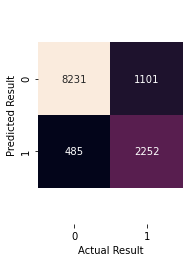

In [661]:
mat = confusion_matrix(y_pred_rf,test_y_rf)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [663]:
fbwx_w2v_rf_performance = classification_report(test_y_rf, y_pred_rf,digits=4,output_dict=True)
performance = fbwx_w2v_rf_performance
model_name = 'fbwx_w2v_Ramdom Forest'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.874669,0.756842,0.800905,0.778250,3315,0.922933,0.902592,0.912649,8757,0.839887,0.851749,0.845450,12072,0.877324,0.874669,0.875743,12072
TF-IDF_CNN_naive_resampling,0.882455,0.824658,0.726395,0.772414,3315,0.900896,0.941532,0.920766,8757,0.862777,0.833964,0.846590,12072,0.879961,0.882455,0.880028,12072
fbwx_w2v_LR,0.869252,0.796409,0.706430,0.748726,3328,0.892838,0.931244,0.911636,8741,0.844623,0.818837,0.830181,12069,0.866248,0.869252,0.866714,12069
fbwx_w2v_LR_naive_resampling,0.869086,0.793294,0.700336,0.743922,3277,0.892982,0.931984,0.912066,8792,0.843138,0.816160,0.827994,12069,0.865914,0.869086,0.866411,12069
fbwx_w2v_linear_SVM,0.867346,0.798162,0.699374,0.745509,3353,0.889607,0.931964,0.910293,8716,0.843884,0.815669,0.827901,12069,0.864202,0.867346,0.864513,12069
fbwx_w2v_linear_SVM_naive_resampling,0.841163,0.666281,0.858038,0.750098,3353,0.938589,0.834672,0.883585,8716,0.802435,0.846355,0.816842,12069,0.862936,0.841163,0.846500,12069
fbwx_w2v_poly_SVM C=0.1,0.851272,0.849327,0.564867,0.678488,3353,0.851713,0.961450,0.903261,8716,0.850520,0.763159,0.790874,12069,0.851050,0.851272,0.840815,12069
fbwx_w2v_poly_SVM C=1,0.876295,0.833812,0.692812,0.756801,3353,0.889044,0.946879,0.917051,8716,0.861428,0.819846,0.836926,12069,0.873700,0.876295,0.872530,12069
fbwx_w2v_poly_SVM(C=0.1)_naive_resampling,0.842158,0.666820,0.863108,0.752372,3353,0.940613,0.834098,0.884159,8716,0.803717,0.848603,0.818266,12069,0.864548,0.842158,0.847546,12069
fbwx_w2v_poly_SVM(C=1)_naive_resampling,0.863286,0.708140,0.864002,0.778345,3353,0.942843,0.863011,0.901162,8716,0.825491,0.863506,0.839754,12069,0.877638,0.863286,0.867041,12069


### Model 5.2 现有样本数据训练word2vec + Random Forest + Random Naive Resampling

In [664]:
X_resampling = np.array(train_X_rf)
y_resampling = train_y_rf
ros = RandomOverSampler(random_state=0)
X_resampled_naive, y_resampled_naive = ros.fit_resample(X_resampling, y_resampling)

In [665]:
startTime = time.time()
rfc_model.fit(X_resampled_naive,y_resampled_naive)
usedTime = time.time() - startTime
usedTime

107.5807843208313

In [666]:
y_pred_rf = rfc_model.predict(test_X_rf)
print(classification_report(test_y_rf, y_pred_rf,digits=4))

              precision    recall  f1-score   support

           0     0.9016    0.9259    0.9136      8716
           1     0.7928    0.7373    0.7640      3353

    accuracy                         0.8735     12069
   macro avg     0.8472    0.8316    0.8388     12069
weighted avg     0.8714    0.8735    0.8720     12069



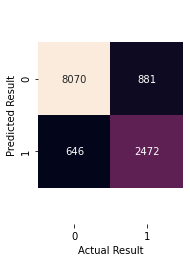

In [667]:
mat = confusion_matrix(y_pred_rf,test_y_rf)
sns.heatmap(mat, square=True, annot=True, cbar=False,fmt='.20g')
plt.xlabel("Actual Result")
plt.ylabel("Predicted Result")
a, b = plt.ylim() 
a += 0.5 
b -= 0.5 
plt.ylim(a, b) 
plt.show() 

In [668]:
fbwx_w2v_rf_naive_resampling_performance = classification_report(test_y_rf, y_pred_rf,digits=4,output_dict=True)
performance = fbwx_w2v_rf_naive_resampling_performance
model_name = 'fbwx_w2v_Ramdom Forest naive_resampling'
performance_df = sklearn_perform(model_name,performance,performance_df)
performance_df

,accuracy,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
TF-IDF_CNN,0.874669,0.756842,0.800905,0.778250,3315,0.922933,0.902592,0.912649,8757,0.839887,0.851749,0.845450,12072,0.877324,0.874669,0.875743,12072
TF-IDF_CNN_naive_resampling,0.882455,0.824658,0.726395,0.772414,3315,0.900896,0.941532,0.920766,8757,0.862777,0.833964,0.846590,12072,0.879961,0.882455,0.880028,12072
fbwx_w2v_LR,0.869252,0.796409,0.706430,0.748726,3328,0.892838,0.931244,0.911636,8741,0.844623,0.818837,0.830181,12069,0.866248,0.869252,0.866714,12069
fbwx_w2v_LR_naive_resampling,0.869086,0.793294,0.700336,0.743922,3277,0.892982,0.931984,0.912066,8792,0.843138,0.816160,0.827994,12069,0.865914,0.869086,0.866411,12069
fbwx_w2v_linear_SVM,0.867346,0.798162,0.699374,0.745509,3353,0.889607,0.931964,0.910293,8716,0.843884,0.815669,0.827901,12069,0.864202,0.867346,0.864513,12069
fbwx_w2v_linear_SVM_naive_resampling,0.841163,0.666281,0.858038,0.750098,3353,0.938589,0.834672,0.883585,8716,0.802435,0.846355,0.816842,12069,0.862936,0.841163,0.846500,12069
fbwx_w2v_poly_SVM C=0.1,0.851272,0.849327,0.564867,0.678488,3353,0.851713,0.961450,0.903261,8716,0.850520,0.763159,0.790874,12069,0.851050,0.851272,0.840815,12069
fbwx_w2v_poly_SVM C=1,0.876295,0.833812,0.692812,0.756801,3353,0.889044,0.946879,0.917051,8716,0.861428,0.819846,0.836926,12069,0.873700,0.876295,0.872530,12069
fbwx_w2v_poly_SVM(C=0.1)_naive_resampling,0.842158,0.666820,0.863108,0.752372,3353,0.940613,0.834098,0.884159,8716,0.803717,0.848603,0.818266,12069,0.864548,0.842158,0.847546,12069
fbwx_w2v_poly_SVM(C=1)_naive_resampling,0.863286,0.708140,0.864002,0.778345,3353,0.942843,0.863011,0.901162,8716,0.825491,0.863506,0.839754,12069,0.877638,0.863286,0.867041,12069


### Model 6.1 现有样本数据训练word2vec + Extra Trees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
et_model=ExtraTreesClassifier()

### Model 7.1 现有样本数据训练word2vec + Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb_model=GaussianNB()

### Model 8.1 现有样本数据训练word2vec + KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_model=KNeighborsClassifier()

### Model 4.1: zhihu word vectors + cnn

#### 0.需要的库

In [ ]:
# 首先加载必用的库，jieba和gensim专门中文 
# %matplotlib inline功能是可以内嵌绘图，并且可以省略掉plt.show()这一步
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import re #正则化用
import jieba # 中文必须用【结巴分词】，因为计算机不会断句
# gensim用来加载预训练word vector
from gensim.models import KeyedVectors
#KeyedVectors实现实体（单词、文档、图片都可以）和向量之间的映射，实体都用string id表示
#有时候运行代码时会有很多warning输出，如提醒新版本之类的，如果不想乱糟糟的输出可以这样
import warnings
warnings.filterwarnings("ignore")

#### 1.预训练词向量

In [ ]:
cn_model = KeyedVectors.load_word2vec_format('sgns.zhihu.bigram', 
                                          binary=False)

#### 2.词向量模型

In [ ]:
# 由此可见每一个词都对应一个长度为300的向量
embedding_dim = cn_model['建筑'].shape[0]  #一词山东大学，shape[0]返回行数
print('词向量的长度为{}'.format(embedding_dim))
#cn_model['建筑']

In [ ]:
# 计算相似度
cn_model.similarity('伤亡', '事故')

In [ ]:
# dot（'橘子'/|'橘子'|， '橙子'/|'橙子'| ），余弦相似度
np.dot(cn_model['伤亡']/np.linalg.norm(cn_model['伤亡']), 
cn_model['事故']/np.linalg.norm(cn_model['事故']))

In [ ]:
# 找出最相近的词，余弦相似度
cn_model.most_similar(positive=['事故'], topn=10)

In [ ]:
# 找出不同的词
test_words = '事故 故障 爆炸事件 死亡 建筑'
test_words_result = cn_model.doesnt_match(test_words.split())
print('在 '+test_words+' 中:\n不是同一类别的词为: %s' %test_words_result)

In [ ]:
cn_model.most_similar(positive=['建筑','事故'], negative=['工程'], topn=1)

#### 3.训练语料 （数据集）

In [ ]:
# 我们使用tensorflow的keras接口来建模
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional#Dense全连接
#Bidirectional双向LSTM  callbacks用来调参
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import models

In [ ]:
# 我们使用tensorflow的keras接口来建模
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional#Dense全连接
#Bidirectional双向LSTM  callbacks用来调参
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau


#### 4.分词和tokenize

In [ ]:
train_tokens = newvalues['baidu_seg'].tolist()

In [ ]:
train_tokens = []
for row_idx in range(newvalues.shape[0]):
    cut_list = newvalues.loc[row_idx, 'baidu_seg'].copy()
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            cut_list[i] = 0
    train_tokens.append(cut_list)

In [ ]:
newvalues.loc[0, 'baidu_seg']

#### 5.索引长度标准化
因为每段评语的长度是不一样的，我们如果单纯取最长的一个评语，并把其他评填充成同样的长度，这样十分浪费计算资源，所以我们取一个折衷的长度。

In [ ]:
# 获得所有tokens的长度
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)


In [ ]:
# 平均tokens的长度
np.mean(num_tokens)

In [ ]:
# 最长的评价tokens的长度
np.max(num_tokens)

In [ ]:
plt.hist(np.log(num_tokens), bins = 100)#有大有小取对数
plt.xlim((3,6))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [ ]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

In [ ]:
# 取tokens的长度为1806时，大约95%的样本被涵盖
# 我们对长度不足的进行padding，超长的进行修剪
np.sum( num_tokens < max_tokens ) / len(num_tokens)

#### 6.反向tokenize
为了之后来验证 我们定义一个function，用来把索引转换成可阅读的文本，这对于debug很重要。

In [ ]:
# 用来将tokens转换为文本
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text


In [ ]:
reverse = reverse_tokens(train_tokens[100])
reverse

In [ ]:
newvalues.loc[100, 'baidu_seg']

#### 7.构建embedding matrix
现在我们来为模型准备embedding matrix（词向量矩阵），根据keras的要求，我们需要准备一个维度为(numwords, embeddingdim)的矩阵【num words代表我们使用的词汇的数量，emdedding dimension在我们现在使用的预训练词向量模型中是300，每一个词汇都用一个长度为300的向量表示】注意我们只选择使用前50k个使用频率最高的词，在这个预训练词向量模型中，一共有260万词汇量，如果全部使用在分类问题上会很浪费计算资源，因为我们的训练样本很小，一共只有4k，如果我们有100k，200k甚至更多的训练样本时，在分类问题上可以考虑减少使用的词汇量。

In [ ]:
# 只使用大库前50000个词
num_words = 100000
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 50000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')


In [ ]:
# 检查index是否对应，
# 输出300意义为长度为300的embedding向量一一对应
np.sum( cn_model[cn_model.index2word[333]] == embedding_matrix[333] )

In [ ]:
# embedding_matrix的维度，
# 这个维度为keras的要求，后续会在模型中用到
embedding_matrix.shape

In [ ]:
train_tokens[0]

In [ ]:
# 进行padding和truncating， 输入的train_tokens是一个list
# 返回的train_pad是一个numpy array
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')


In [ ]:
len(train_pad[1])

In [ ]:
pd.DataFrame(train_pad[11]).shape

In [ ]:
# 超出9000个词向量的词用0代替
train_pad[train_pad >= num_words ] = 0

In [ ]:
# 可见padding之后前面的tokens全变成0，文本在最后面
train_pad[1003]

In [ ]:
# pd.DataFrame(train_pad[10])[0].value_counts()
# 训练样本专业性很强，而预训练的词向量所用文本包含许多领域

In [ ]:
train_target = newvalues.label

In [ ]:
# 进行训练和测试样本的分割
from sklearn.model_selection import train_test_split


In [ ]:
train_target.shape
train_pad.shape

In [ ]:
# 90%的样本用来训练，剩余10%用来测试
#因为前2000个文件夹都是neg一类，所以打乱顺序来训练 random_state
X_train, X_test, y_train, y_test = train_test_split(train_pad,
                                                    train_target,
                                                    test_size=0.1,
                                                    random_state=12
                                                    )


In [ ]:
import random
X_train = random.sample(train_pad.tolist(), train_pad.shape[0]*0.7) # 结果['a', 'd', 'b', 'f', 'c']，每次运行结果不同。

In [ ]:
reverse = reverse_tokens(train_tokens[0])
reverse